In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, freqz

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.data import utils, stamp_correction
from sleeprnn.helpers import reader, plotter, printer, misc, performer

%matplotlib inline
viz.notebook_full_width()

In [7]:
dataset_name = constants.MASS_SS_NAME
fs = 200
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


# RED performance (Validation, IoU >= 0.2)
Performance of RED-CWT model as a reference for exploratory analysis: We would like to find explanations to the errors, and to design new methods to deal with them and improve the model.

In [8]:
# Precision, Recall, and their difference per subject (color by seed or indicate in some way, duplicate S05?).


# Change in performance after FFT-based normalization

In [ ]:
# Same plots as before and also plots of scaling factors normalized by their mean (to know which one was scaled up or down)

# General Exploratory Analysis

# Spindle parameters

In [9]:
def analyze_spindle(spindle, fs):
    duration = spindle.size / fs
    pp_amplitude = spindle.max() - spindle.min()
    rms = np.sqrt(np.mean(spindle ** 2))
    central_freq_count = find_peaks(spindle)[0].size / duration
    # Compute peak frequency by fft
    w, h = freqz(spindle)
    resp_freq = w * fs / (2*np.pi)
    resp_amp = abs(h)
    max_loc = np.argmax(resp_amp)
    central_freq_fft = resp_freq[max_loc]
    results = {
        'duration': duration,
        'pp_amplitude': pp_amplitude,
        'rms': rms,
        'central_freq_count': central_freq_count,
        'central_freq_fft': central_freq_fft
    }
    return results


def listify_dictionaries(list_of_dicts):
    dict_of_lists = {}
    for key in list_of_dicts[0].keys():
        dict_of_lists[key] = []
        for single_dict in list_of_dicts:
            dict_of_lists[key].append(single_dict[key])
    return dict_of_lists

In [10]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    sigma_signal = utils.broad_filter(signal, fs, lowcut=9, highcut=17)
    spindles = [sigma_signal[s_start:s_end] for (s_start, s_end) in stamps]
    analysis = []
    for spindle in spindles:
        analysis_results = analyze_spindle(spindle, fs)
        analysis.append(analysis_results)
    analysis = listify_dictionaries(analysis)
    train_analysis.append(analysis)

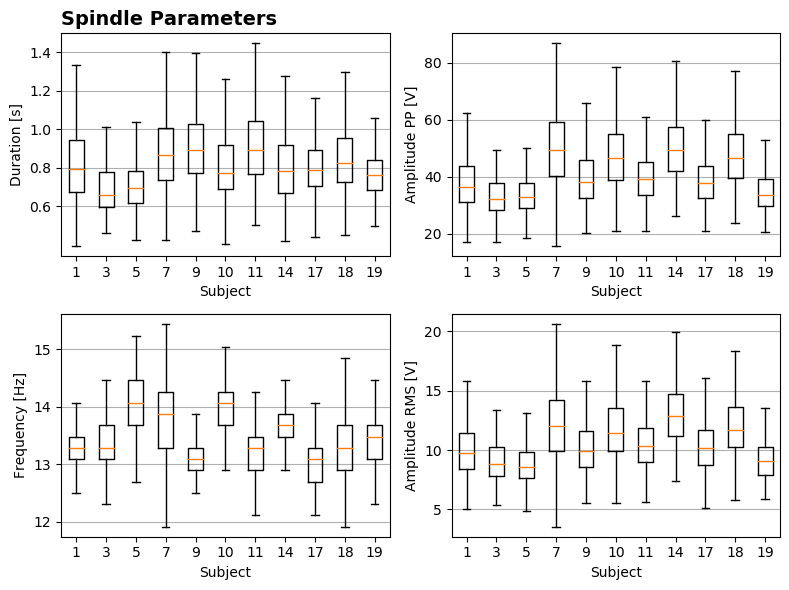

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=100)
showfliers = False

axes[0, 0].set_title("Spindle Parameters", fontweight='bold', loc="left", fontsize=14)

# Duration
ax = axes[0, 0]
ax.set_ylabel("Duration [s]")
ax.boxplot(
    [analysis['duration'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_xlabel("Subject")
ax.set_yticks([0.6, 0.8, 1.0, 1.2, 1.4])

# Frequency
ax = axes[1, 0]
ax.set_ylabel("Frequency [Hz]")
ax.boxplot(
    [analysis['central_freq_fft'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_yticks([12, 13, 14, 15])
ax.set_xlabel("Subject")

# Amplitude PP
ax = axes[0, 1]
ax.set_ylabel("Amplitude PP [V]")
ax.boxplot(
    [analysis['pp_amplitude'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_yticks([20, 40, 60, 80])
ax.set_xlabel("Subject")

# Amplitude RMS
ax = axes[1, 1]
ax.set_ylabel("Amplitude RMS [V]")
ax.boxplot(
    [analysis['rms'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_xlabel("Subject")
ax.set_yticks([5, 10, 15, 20])

plt.tight_layout()
plt.show()

# Spectral parameters

In [12]:
def fft_based_scaling(signal, fs, pages, page_size):
    # Using FFT on whole page
    amp_all = []
    window_han = np.hanning(page_size)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        amp, _ = utils.power_spectrum(window_han * signal[start_page:end_page], fs)
        amp_all.append(amp)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    scaling_factor = 1 / np.mean(amp_all)
    return scaling_factor


def normalized_spectrum(signal, fs, pages, page_size):
    # Using FFT on whole page
    amp_all = []
    freq_all = []
    window_han = np.hanning(page_size)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        amp, freq = utils.power_spectrum(window_han * signal[start_page:end_page], fs)
        amp_all.append(amp)
        freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    # amp_all = amp_all / np.mean(amp_all)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    spectrum_page = np.stack([freq_all, amp_all], axis=1)
    
    # Using FFT on 2-seconds segments
    amp_all = []
    freq_all = []
    window_size = 2 * fs
    window_han = np.hanning(window_size)
    n_windows = int(2 * (page_size / window_size) - 1)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        segment_signal = signal[start_page:end_page]
        for i in range(n_windows):
            start_window = int(i * window_size / 2)
            end_window = start_window + window_size
            window_signal = segment_signal[start_window:end_window] * window_han
            padding = np.zeros(1 * fs)
            window_signal_extended = np.concatenate([padding, window_signal, padding])
            amp, freq = utils.power_spectrum(window_signal_extended, fs)
            amp_all.append(amp)
            freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    # amp_all = amp_all / np.mean(amp_all)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    spectrum_window = np.stack([freq_all, amp_all], axis=1)
    
    results = {
        'spectrum_page': spectrum_page,
        'spectrum_window': spectrum_window
    }
    return results

In [16]:
print("Correction factors if we want normalized FFT (integral equal to 1)")
mean_fft_scaling = 0
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size)
    mean_fft_scaling += scaling_factor
    print("Subject %02d: %1.6f" % (subject_id, scaling_factor))
mean_fft_scaling /= len(dataset.train_ids)
print("Mean FFT Scaling: %1.6f" % mean_fft_scaling)

Correction factors if we want normalized FFT (integral equal to 1)
Subject 01: 10.916494
Subject 03: 11.553214
Subject 05: 12.373606
Subject 07: 9.929915
Subject 09: 10.336481
Subject 10: 9.480714
Subject 11: 11.303516
Subject 14: 9.269004
Subject 17: 10.320328
Subject 18: 8.929854
Subject 19: 13.672083
Mean FFT Scaling: 10.735019


In [14]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    scaling_factor = 1.0
    #scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size)
    analysis_results = normalized_spectrum(signal * scaling_factor, fs, n2_pages, dataset.page_size)    
    train_analysis.append(analysis_results)

spectrum_window


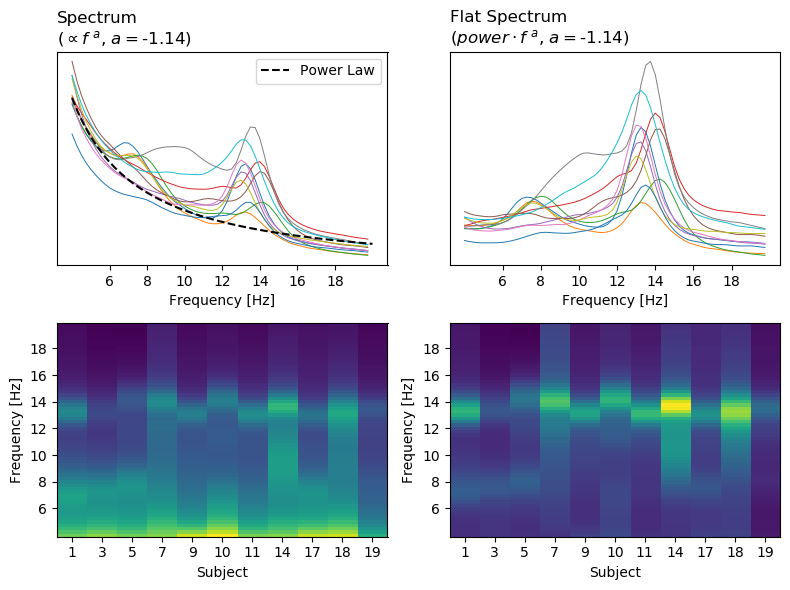

In [15]:
for chosen_key in ["spectrum_window"]:
    print(chosen_key)
    
    # Find tendency
    fit_lowcut = 1
    fit_highcut = 25
    coeffs = []
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - fit_lowcut) ** 2)
        last_freq_loc = np.argmin((freq_full - fit_highcut) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]        
        fit_x = np.log(freq)
        fit_y = np.log(power)
        coeff = np.polyfit(fit_x, fit_y, 1)
        coeffs.append(coeff)
    coeffs = np.stack(coeffs, axis=0).mean(axis=0)
    def tendency(frequencies):
        result = np.exp(coeffs[1]) * (frequencies ** coeffs[0])
        return result
    def flatten(frequencies, power):
        result = power / (frequencies ** coeffs[0])
        return result
    
    # Plots
    first_freq = 4#6
    last_freq = 20#18    
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=100)
    
    # Raw spectrum
    ax = axes[0, 0]
    subjects_spectrum_raw = []
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        ax.plot(freq, power, linewidth=0.7)
        spectrum_raw = np.stack([freq, power], axis=1)
        subjects_spectrum_raw.append(spectrum_raw)
    regr_freq = np.linspace(first_freq, last_freq)
    ax.plot(regr_freq, tendency(regr_freq), '--k', linewidth=1.5, label="Power Law")
    ax.legend(loc="upper right")
    ax.set_yticks([])
    ax.set_xticks([6, 8, 10, 12, 14, 16, 18])
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("Spectrum\n($\propto f^{\ a}$, $a=$%1.2f)" % coeffs[0], loc="left")
    
    ax = axes[1, 0]
    spectrum_image = np.stack([spectrum[:, 1] for spectrum in subjects_spectrum_raw], axis=0)
    freq_axis = subjects_spectrum_raw[0][:, 0]
    n_freqs = freq_axis.size
    show_freqs = np.array([6, 8, 10, 12, 14, 16, 18])
    show_ticks = (n_freqs - 1) * (show_freqs - freq_axis[0]) / (freq_axis[-1] - freq_axis[0])
    ax.imshow(spectrum_image.T, origin="lower", aspect="auto", interpolation="none")
    ax.set_xticks(np.arange(spectrum_image.shape[0]))
    ax.set_xticklabels(dataset.train_ids)
    ax.set_yticks(show_ticks)
    ax.set_yticklabels(show_freqs)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xlabel("Subject")
    
    # Flat spectrum
    ax = axes[0, 1]
    subjects_spectrum_flat = []
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        power = flatten(freq, power)
        ax.plot(freq, power, linewidth=0.7)
        spectrum_flat = np.stack([freq, power], axis=1)
        subjects_spectrum_flat.append(spectrum_flat)
    ax.set_yticks([])
    ax.set_xticks([6, 8, 10, 12, 14, 16, 18])
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("Flat Spectrum \n($power\cdot f^{\ a}$, $a=$%1.2f)" % coeffs[0], loc="left")
    
    ax = axes[1, 1]
    spectrum_image = np.stack([spectrum[:, 1] for spectrum in subjects_spectrum_flat], axis=0)
    freq_axis = subjects_spectrum_flat[0][:, 0]
    n_freqs = freq_axis.size
    show_freqs = np.array([6, 8, 10, 12, 14, 16, 18])
    show_ticks = (n_freqs - 1) * (show_freqs - freq_axis[0]) / (freq_axis[-1] - freq_axis[0])
    ax.imshow(spectrum_image.T, origin="lower", aspect="auto", interpolation="none")
    ax.set_xticks(np.arange(spectrum_image.shape[0]))
    ax.set_xticklabels(dataset.train_ids)
    ax.set_yticks(show_ticks)
    ax.set_yticklabels(show_freqs)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xlabel("Subject")
    
    plt.tight_layout()
    plt.show()

# Spindle spectral parameters
Like power ratios and spectrum of 2s centered on spindle